# Code from 
https://github.com/jsikyoon/SequentialData-GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import pickle
import os, time, itertools, imageio, pickle
import shutil
import uuid
import yaml
from sklearn import preprocessing

# set the tensorflow verbosity
tf.logging.set_verbosity(tf.logging.DEBUG)

In [3]:
# load MNIST
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
img_height = 28
img_width = 28
img_size = img_height * img_width

tr_data_num=60000;
seq_size=4
to_train = True
to_restore = True
output_path = "output"

h1_size = 150
h2_size = 300
z_size = 100
batch_size = 256
seq_size=4
n_hidden=300
tr_data_num=60000;
g_num_layers=2;
d_num_layers=2;
learning_rate = 0.00001

log_dir="/tmp/gan_seq/"+str(int(time.time()))


In [5]:
total_tr_data, total_tr_label = mnist.train.next_batch(mnist.train._num_examples); #55000
total_tr_data=np.array(total_tr_data,dtype=float);               #(55000, 784)
total_tr_label=np.array(total_tr_label,dtype=float);             #(55000, 10)
tr_data=np.zeros((tr_data_num,seq_size,img_size),dtype=object);  #(60000, 4, 784)

for i in range(seq_size):  #4
    total_idx=np.where(total_tr_label[:,i]==1.0)[0];           
    
    while(len(total_idx)<tr_data_num): #90208 < 60000
        total_idx=np.append(total_idx,total_idx);

    np.random.shuffle(total_idx);
    selected_idx=total_idx[:tr_data_num];         
    tr_data[:,i,:]=total_tr_data[selected_idx];   

In [6]:
# define the input placeholders
x_data = tf.placeholder(tf.float32, [None, seq_size, img_size], name="x_data")  #(batch_size, 4, 784)
z_prior = tf.placeholder(tf.float32, [None, seq_size, z_size], name="z_prior")  #(batch_size, 4, 100)
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
global_step = tf.Variable(0, name="global_step", trainable=False)


In [7]:
def save_model_state(saver, sess, path):
    # save the model state
    if not os.path.exists(os.path.split(path)[0]):
        os.makedirs(os.path.split(path)[0])
    else:
        saver.save(sess, path)

In [8]:
def show_result(test_images, num_epoch, show = False, save = False, path = 'result.png'): 
    n_sample = 25
    

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid 
        j = k % size_figure_grid  
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')  

    if save:
        plt.savefig(path)  
    if show:
        plt.show()        
    else:
        plt.close()    

In [9]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4) 
    plt.grid(True)
    plt.tight_layout()
    plt.title("Training Losses")
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [10]:
def restore_checkpoint_status(saver, sess, path):
    # check if the checkpoint exists for this experiment
    dir_path = os.path.split(path)[0] if os.path.splitext(path)[1] else path
    if not tf.train.latest_checkpoint(dir_path):
        print('No checkpoint found. Starting training.....')
        return False
    
    # else resume the training
    print('Checkpoint found for this experiment.Restoring variables.....')
    saver.restore(sess, path)
    return True

In [11]:
def build_generator(z_prior,keep_prob): 
    
    z_in = z_prior  #  (batch_size, 4, 100)
    
    with tf.variable_scope("gen") as gen:
        
        weights=tf.Variable(tf.random_normal([n_hidden, img_size]));  #(300,784)
        biases=tf.Variable(tf.random_normal([img_size]));  #(784)
        
        lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(n_hidden),
                                                 output_keep_prob=keep_prob)for _ in range(g_num_layers)]);   # 300*2
        init_state=lstm_cell.zero_state(batch_size,dtype=tf.float32)
        res, states = tf.nn.dynamic_rnn(lstm_cell, z_in,initial_state=init_state,dtype=tf.float32);

        t_g3 = res #(batch_size, 4, 300)
        t_g4 = states

        res=tf.nn.tanh(tf.matmul(res, weights) + biases); # res =(batch_size, 4, 784) 
            
    return res,t_g3,t_g4   

In [12]:
def build_discriminator(x_data, keep_prob):
    
    x_in = x_data    #(batch_size, 4, 784)
        
    with tf.variable_scope("dis", reuse = tf.AUTO_REUSE) as dis:
        
        weights=tf.Variable(tf.random_normal([n_hidden, 1]));  #(300, 1)
        biases=tf.Variable(tf.random_normal([1]));  #(1)
        
        lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(n_hidden), 
                                                 output_keep_prob=keep_prob) for _ in range(d_num_layers)]); # 300*2
        init_state=lstm_cell.zero_state(batch_size,dtype=tf.float32)
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, x_in,initial_state=init_state,dtype=tf.float32);

        t_d8 = outputs  #(batch_size, 4, n_hidden = 300)
        t_d9 = states   #(batch_size, n_hidden = 300)
        
        res=tf.matmul(outputs[:,-1,:], weights) + biases;  
        t_d10 = res    #(batch_size, 1)  

        y_data = tf.nn.sigmoid(tf.slice(res, [0, 0], [batch_size, -1], name=None));
        t_d11 = y_data  #(256, 1)
            
    return y_data,t_d8,t_d9,t_d10,t_d11,lstm_cell

In [13]:
# networks : generator
x_generated,t_g3,t_g4 = build_generator(z_prior,keep_prob);

# networks : discriminator
y_data, t_d8,t_d9,t_d10,t_d11,lstm_cell = build_discriminator(x_data, keep_prob)   
y_generated, t_d8,t_d9,t_d10,t_d11,lstm_cell = build_discriminator(x_generated, keep_prob) 

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_data, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_generated, labels=tf.zeros([batch_size, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_generated, labels=tf.ones([batch_size, 1])))


# define the optimizer ops
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('dis')]
G_vars = [var for var in T_vars if var.name.startswith('gen')]

# optimizer  
d_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=D_vars)
g_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=G_vars)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as

In [14]:
# results save folder
root = 'MNIST_GAN_LSTM_results_new/'
model = 'MNIST_GAN_LSTM_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

    
"""
Defines the experiment id for a experiment.
Make sure to update the experiment id when running the code using a new set of hyperparameters
"""
experiment_id = '1'
checkpoint_path = os.path.join(root, 'checkpoints', 'model-{}.ckpt'.format(experiment_id))
# checkpoint_path = os.path.join(root, 'checkpoints')


training start!
[1/10] loss_d: 1.013, loss_g: 0.690


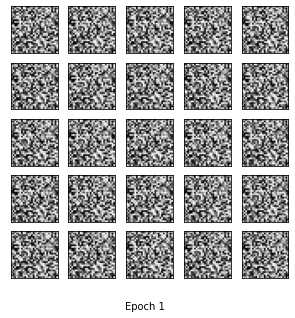

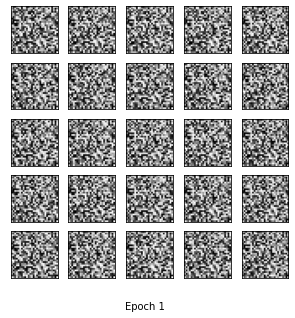

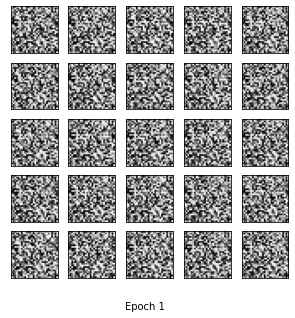

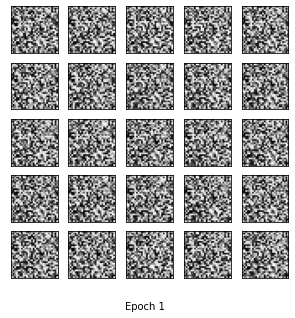

[2/10] loss_d: 1.007, loss_g: 0.693


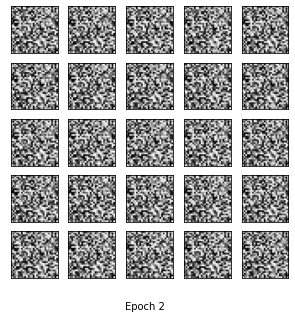

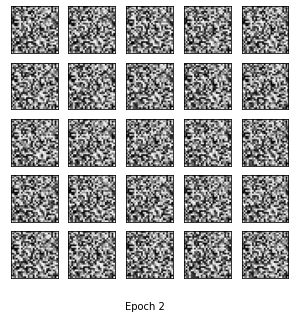

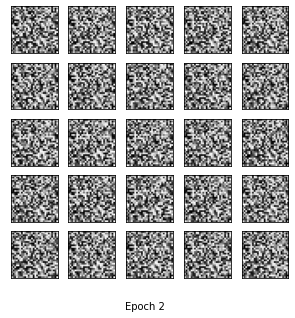

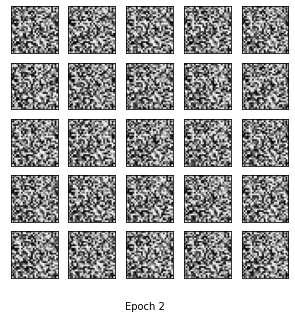

[3/10] loss_d: 1.006, loss_g: 0.693


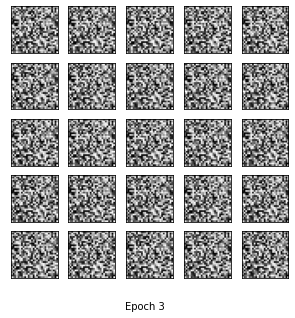

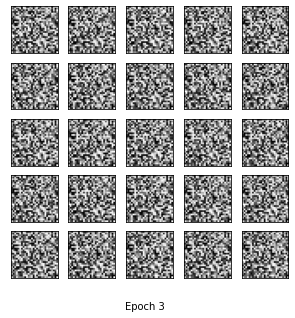

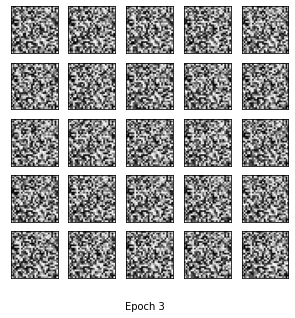

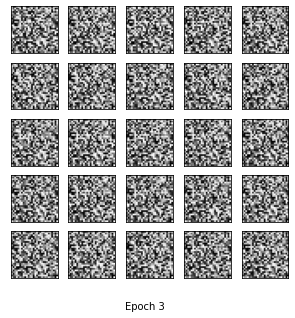

[4/10] loss_d: 1.006, loss_g: 0.693


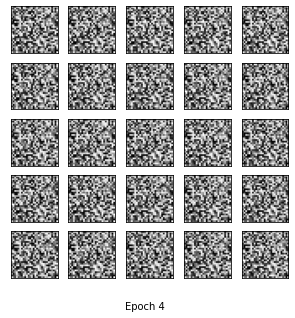

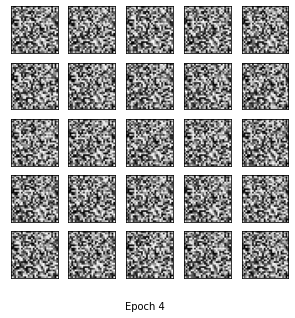

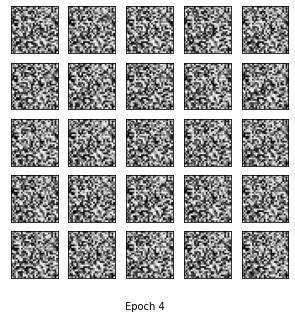

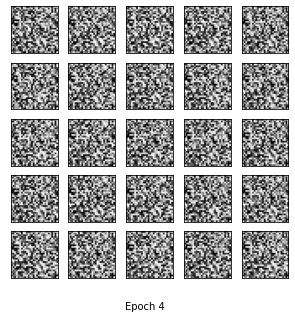

[5/10] loss_d: 1.006, loss_g: 0.693


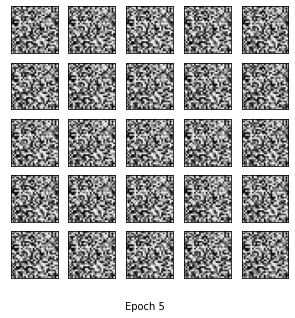

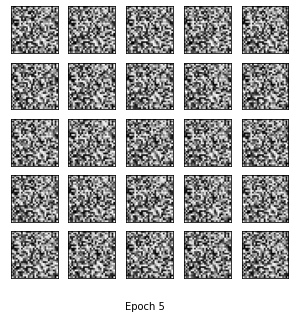

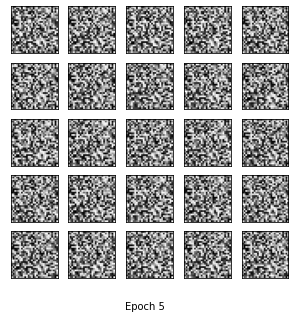

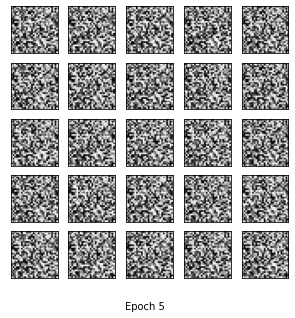

[6/10] loss_d: 1.006, loss_g: 0.693


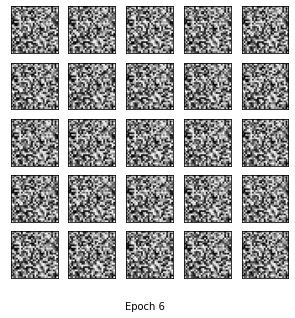

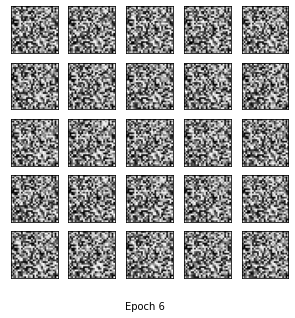

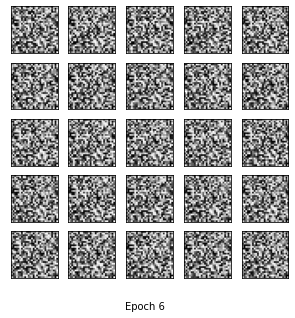

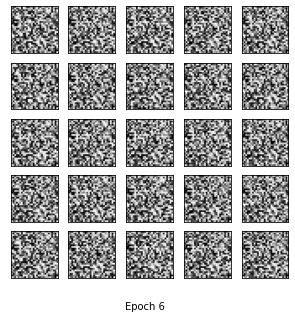

[7/10] loss_d: 1.006, loss_g: 0.693


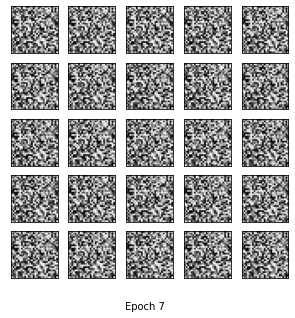

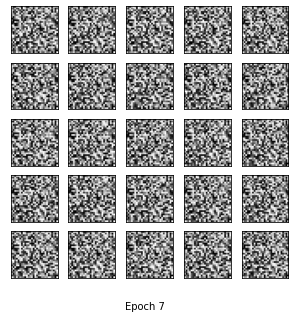

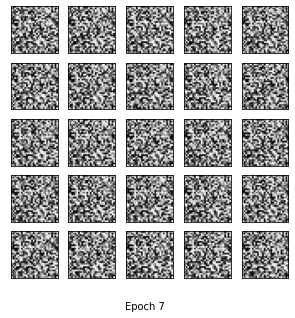

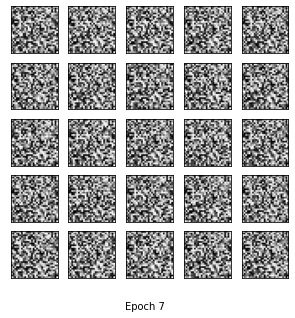

[8/10] loss_d: 1.006, loss_g: 0.693


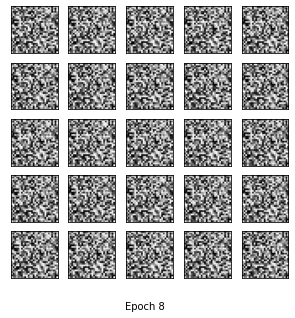

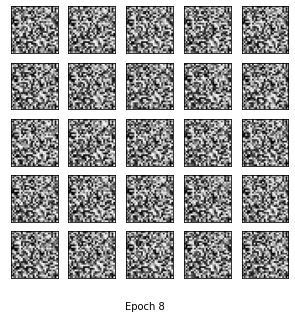

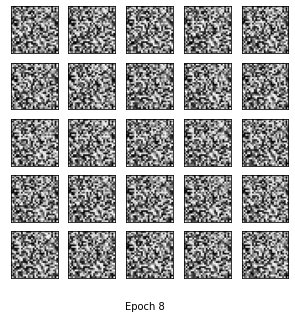

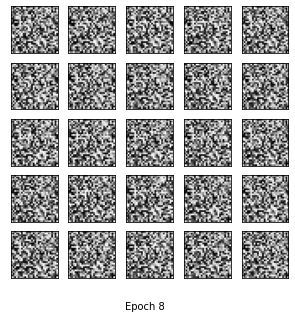

[9/10] loss_d: 1.006, loss_g: 0.693


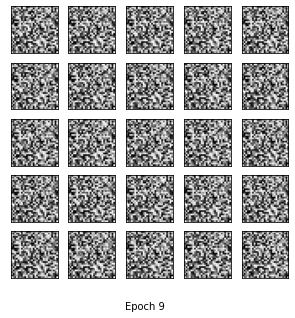

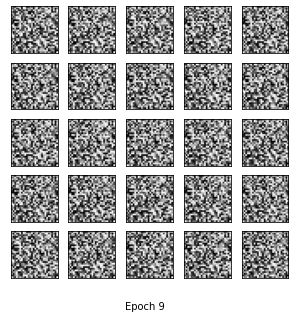

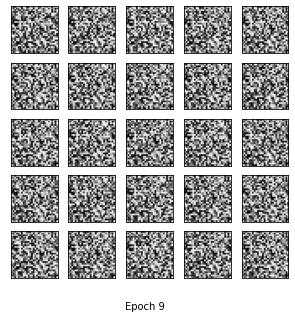

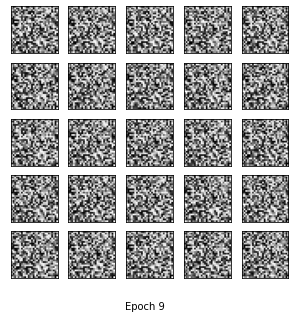

[10/10] loss_d: 1.006, loss_g: 0.693


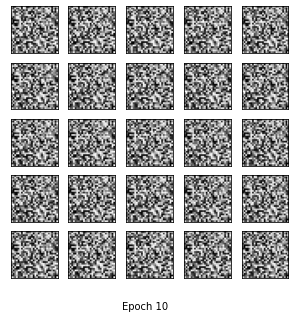

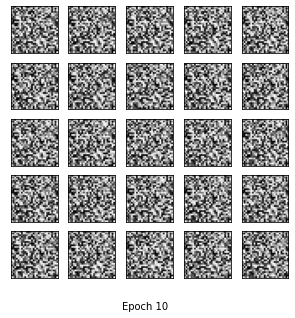

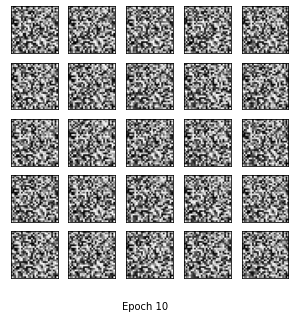

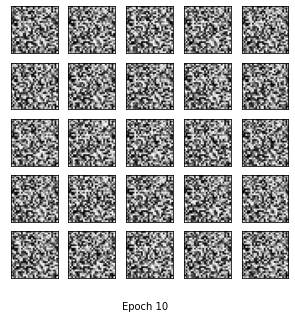

Training finish!


In [15]:
batch_size = 256
seq_size=4
z_size = 100
max_epoch = 10
n_critic = 1

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

# define the session variable
saver = tf.train.Saver()

gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(tf.global_variables_initializer())
    # define the optimization procedure  
    print('training start!')
    
    z_sample_val = np.random.normal(0, 1, size=(batch_size, seq_size, z_size)).astype(np.float32) #(256, 4, 100)
    z_sample_val[:,1:,:]=0.0;  

    for i in range(max_epoch):
        G_losses = []
        D_losses = []
        for j in range(int(tr_data_num / batch_size)):  # 60000/256 = 234
            
    #       optimize the discriminator network
            x_value = tr_data[j*batch_size:(j+1)*batch_size]; 
            x_value = 2 * x_value.astype(np.float32) - 1  
        
            z_value = np.random.normal(0, 1, size=(batch_size, seq_size, z_size)).astype(np.float32) #(256, 4, 100)
            z_value[:,1:,:]=0.0; 
            
            _, discriminator_loss = sess.run([d_trainer,D_loss],
                    feed_dict={x_data: x_value, 
                               z_prior: z_value, 
                               keep_prob: np.sum(0.7).astype(np.float32)})
            D_losses.append(discriminator_loss) 
            
    #         optimize the generator network
            if j % n_critic == 0: # Train the generator every n_critic iterations
                
                _,generator_loss = sess.run([g_trainer,G_loss],
                      feed_dict={x_data: x_value, 
                                 z_prior: z_value, 
                                 keep_prob: np.sum(1).astype(np.float32)})
                G_losses.append(generator_loss)
                
        print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((i + 1),max_epoch,np.mean(D_losses), np.mean(G_losses)))
        train_hist['D_losses'].append(np.mean(D_losses))
        train_hist['G_losses'].append(np.mean(G_losses))  

        for j in range(seq_size):
            x_gen_val = sess.run(x_generated[:,j,:], 
                        feed_dict={z_prior: z_sample_val,
                                   keep_prob:np.sum(0.7).astype(np.float32)})          
            save_image_path = root + 'Fixed_results/' + model +str(i)+"_"+str(j)+".png" 
            show_result(x_gen_val, num_epoch = (i + 1), 
                        show = True, save=True, path=save_image_path)
            
        #checkpoint the training
        save_model_state(saver, sess, checkpoint_path)
           
    print("Training finish!")    
    sess.close()

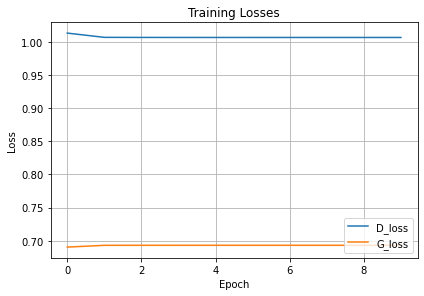

In [16]:
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
    
save_loss_path=root + model + 'train_hist.png' 

show_train_hist(train_hist, show = True,save=True, path=save_loss_path)
